In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
yf.pdr_override()

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#for reporting
from tabulate import tabulate

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Backtest:
    def __init__(self, data, base_, tradingexp_):
        self.data=data
        self.base=base_
        self.tradingexp = tradingexp_
        ## Write any processing that needs to be done on the data
        self.data['Buy_Sell']= self.data['Position'] - self.data['Position'].shift(1)
        self.data['log_return']=np.log(self.data['Adj Close']/self.data['Adj Close'].shift(1))
        self.data['Strategy_return']=self.data['Position'].shift(1)*self.data['log_return']
        self.data['Expense']=np.where(abs(self.data['Buy_Sell'])> 0, self.tradingexp, 0)
        self.data['Capital']= self.base*self.data['Strategy_return'].cumsum().apply(np.exp)
        self.data['Adj Capital'] = self.base*self.data['Strategy_return'].cumsum().apply(np.exp) - self.data['Expense'].shift(1).cumsum()
        self.data['Adj return'] = np.log(self.data['Adj Capital']/self.data['Adj Capital'].shift(1))
        self.data['drawdown']=self.data['Adj return'].cumsum() - self.data['Adj return'].cumsum().cummax()

                
    def plot_backtest_buy_sell(self): 
        ax=\
        (
            self.data[['Adj Close',
                       'Position']]
            .plot(figsize=(18,8),
                  secondary_y=["Position"],
                  style=["red","b--"],
                  alpha=0.5
                 )
        )

        (
            ax.legend(loc="upper center"
                      ,shadow=True
                      ,fancybox=True
                      ,bbox_to_anchor=(0.55,1.10)
                      ,ncol=4
                     )
        )

        bx=\
        (
            self.data[self.data['Buy_Sell']>0]['Adj Close']
            .plot(style="g^",
                  markersize=12,
                  label='Buy')
        )

        bx.legend()

        cx=\
        (
            self.data[self.data['Buy_Sell']<0]['Adj Close']
            .plot(style="rv",
                  markersize=12,
                  label="Sell")
        )
        
        cx.legend()
        plt.title(f"Backtest Buy Sell Signals")
        plt.show()
      
    def calculate_cumm_return(self):
        res=100*(np.exp(self.data['Adj return'].sum()) -1)
        #print(f"Cummulative return is: {res:.2f}% with final Account balance: ${self.data['Adj Capital'].iloc[-1]}")
        return res
    
    def calculate_max_drawdown(self):
        res=100* (np.exp(self.data['drawdown'].min()) - 1)
        #print(f"Max Drawdown: {res:.2f}%")
        return res
    
    def calculate_max_drawdown_duration(self):
        periods =\
        self.data[self.data['drawdown'] == 0].index[ 1 :   ].to_pydatetime() \
        - self.data[self.data['drawdown'] == 0].index[   : -1].to_pydatetime()
        print(f"Max Drawdown Duration: {periods.max()}")

    def calculate_return_byyear(self):
        grpByYear=self.data.groupby(self.data.index.year)
        return grpByYear['Adj return'].sum().apply(np.exp) -1

    def calculate_sharpe_ratio(self):
        res = np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / (self.data['Adj return'].dropna().apply(np.exp).add(-1).std())
        #print(f"Sharpe Ratio: {res:.3f}")
        return res
    
    def calculate_sortino_ratio(self):
        res= np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / np.minimum(self.data['Adj return'].dropna().apply(np.exp).add(-1),0).std()
        return res

    def calculate_cagr(self):
        days =(self.data.index[-1] - self.data.index[0]).days
        CAGR =100*(((np.exp(self.data['Adj return'].sum()))**(365.0/days)) - 1)
        #print(f"Strategy CAGR is: {CAGR:.2f}%")
        return CAGR
        
    def generate_quarterly_returns(self):
        self.data['quarter'] = self.data.index.quarter
        self.data['year'] = self.data.index.year
        result =\
        (
            self.data
            .groupby(['quarter', 'year'])['Adj return']
            .sum()
            .apply(np.exp)
            .add(-1)
            .multiply(100)
            .reset_index(name='Cumulative Return')
        )

        pivot=result.pivot(index='year', columns='quarter', values='Cumulative Return')
        pivot.columns=pivot.columns.map(lambda x: 'Q' + str(x))
        pivot=pivot.round(decimals=5)
        return pivot
        
    def plot_backtest_returns(self):
        ax =\
        (
            self.data[["log_return", "Adj return"]]
            .dropna()
            .cumsum()
            .apply(np.exp)
            .add(-1)
            .plot(figsize = [18, 7])
        )
        
        ax.set_title(f"Back Test Strategy vs Buy&Hold Return")
        ax.legend(["Buy&Hold Cumm Return","Strategy Cumm Return (Adj)"])
        bx =\
        (
            self.data['Adj return']
            .cumsum()
            .cummax()
            .apply(np.exp)
            .add(-1)
            .plot(ax=ax)
        )
        plt.show()
    
    def plot_all_stats(self):
    
        portfolio_stats = pd.DataFrame({
            'Final Account Balance': f"$ {self.data['Adj Capital'].iloc[-1]:.2f}",
            'Cummulative return': f"{self.calculate_cumm_return():.2f}%",
            'Strategy CAGR': f"{self.calculate_cagr():.2f}%",
            'Max Drawdown': f"{self.calculate_max_drawdown():.2f}%",
            'Sharpe Ratio': f"{self.calculate_sharpe_ratio():.3f}",
            'Sortino Ratio': f"{self.calculate_sortino_ratio():.3f}"
        }, index=['Value'])

        portfolio_stats.columns.name='Statistic'

        print(tabulate(portfolio_stats.transpose(), headers='keys', tablefmt='pretty', showindex=True,stralign='right'))

#         print(f"Cummulative return is: {self.calculate_cumm_return():.2f}% with final Account balance: ${self.data['Adj Capital'].iloc[-1]}")
#         print(f"Strategy CAGR is: {self.calculate_cagr():.2f}%")
#         print(f"Max Drawdown: {self.calculate_max_drawdown():.2f}%")
#         print(f"Sharpe Ratio: {self.calculate_sharpe_ratio():.3f}")
#         print(f"Sortino Ratio: {self.calculate_sortino_ratio():.3f}")
        self.plot_backtest_returns()
        print('% Return by Quarter:')
        print(tabulate(self.generate_quarterly_returns(), headers='keys', tablefmt='pretty', showindex=True,stralign='right'))
        self.plot_backtest_buy_sell()


# prepare data

In [3]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)
spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)

Y = np.log(spy["Adj Close"]).diff(1).shift(-1)            
Y.name = "Y_pred"

tnx_ticker = "^TNX" # CBOE 10 Year Treasury Note Yield Index
tnx_data = yf.download(tnx_ticker, start=start_date, end=end_date)

X1 = np.log(tnx_data['Adj Close'])
X1 = X1.ffill()
X1.name='10years futures'

vix_ticker = "^VIX"
vix = yf.download(vix_ticker, start=start_date, end=end_date)
X2 = np.log(vix['Adj Close'])
X2 = X2.ffill()
X2.name='vix'

X3 = np.log(spy['Volume'])

X4 = pd.concat([X1.shift(i) for i in [3,6,12]], axis=1)
X4.columns = ["Volume_3", "Volume_6", "Volume_12"]

X5 = pd.concat([Y.diff(i) for i in [3,6,12]], axis=1)
X5.columns = ["SPY_3", "SPY_6", "SPY_12"]

X = pd.concat([X1, X2, X3, X4, X5], axis=1)

X_traintest = X.loc[pd.to_datetime('2004-11-17'):]
X_traintest = X_traintest.ffill()

Y_traintest = Y.loc[pd.to_datetime('2004-11-17'):]

Y_traintest_binary = (Y_traintest > 0).astype(int)
index_ = Y_traintest_binary.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Feature Engineering

In [4]:
# - original x var = 9
# - degree-1 term = 9
# - degree-2 terms 
#     - 9
#     - interaction 9C2 = 36
# - degree-3 terms
#     - 9
#     - 9C3 = 84
#     - degree-2 term + other degree-1 term = 9 * 8 = 72
# - constant term = 1

# - 9(original)+9(squared)+36(pairwise)+9(cubed)+84(three-way)+72(squared-other)+1(constant)=220

In [6]:
def get_polynomial_features(X_traintest, Y_traintest, *args):
    
    k = arg[0] if args else "all"
    
    Y_traintest_binary = (Y_traintest > 0).astype(int)
    
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X_traintest)

    feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'Volume_3', 'Volume_6', 'Volume_12', 'SPY_3', 'SPY_6', 'SPY_12'])
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
    X_poly_df.index = index_
    
    selector = SelectKBest(score_func=f_regression, k=k) 

    X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
    X_columns = selector.get_feature_names_out()
    X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_traintest)

feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'Volume_3', 'Volume_6', 'Volume_12', 'SPY_3', 'SPY_6', 'SPY_12'])
X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index = index_)

# select the top 10 features based on the F-scores, arbitrary user-input before optimization
selector = SelectKBest(score_func=f_regression, k=10) 

X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
X_columns = selector.get_feature_names_out()
X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)

In [8]:
X_selected_df

,SPY_3,SPY_6,SPY_12,vix SPY_12,Volume SPY_3,Volume SPY_6,Volume SPY_12,Volume^2 SPY_3,Volume^2 SPY_6,Volume^2 SPY_12
Date,,,,,,,,,,
2004-11-17,-0.001106,0.000578,0.000995,0.002568,-0.019703,0.010290,0.017725,-0.350978,0.183306,0.315748
2004-11-18,-0.003993,-0.018758,-0.023693,-0.060734,-0.068991,-0.324076,-0.409334,-1.191939,-5.598961,-7.071931
2004-11-19,-0.001163,-0.003102,-0.008805,-0.022916,-0.020716,-0.055242,-0.156812,-0.368939,-0.983846,-2.792753
2004-11-22,0.000177,-0.000929,-0.004719,-0.012092,0.003080,-0.016211,-0.082302,0.053720,-0.282747,-1.435464
2004-11-23,0.013545,0.009552,0.003817,0.009693,0.237748,0.167656,0.067000,4.173058,2.942766,1.176020
...,...,...,...,...,...,...,...,...,...,...
2023-10-25,-0.010312,0.001368,-0.017238,-0.051804,-0.189344,0.025114,-0.316514,-3.476572,0.461117,-5.811573
2023-10-26,-0.012054,0.004282,-0.008631,-0.026145,-0.223748,0.079485,-0.160207,-4.153158,1.475377,-2.973727
2023-10-27,0.026341,0.024249,0.018000,0.055031,0.487093,0.448408,0.332852,9.007208,8.291855,6.155018


<Axes: >

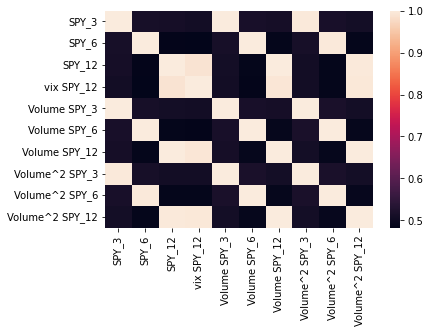

In [9]:
sns.heatmap(X_selected_df.corr())

#notice that there are positive correlations for the original selected features

# Unoptimized results

Linear regression has intercept of 0.560 and coefficients of [-2.07513734e+01  5.20566069e+02  8.92687464e+02 -1.51597164e+01
  9.68517227e+00 -5.00376727e+01 -9.35533649e+01 -4.31800147e-01
  1.20799415e+00  2.60921590e+00]
 
Logistic regression has intercept of 3.896 and coefficients of [ 0.00527887  0.00481117  0.00433162 -0.0131677   0.05326691  0.04808138
  0.04432489  0.13428796  0.0995798   0.13305404]
 
Accuracy of model is : 0.568
 
Precision of model is : 0.559
 
Precision of model is : 0.999
 


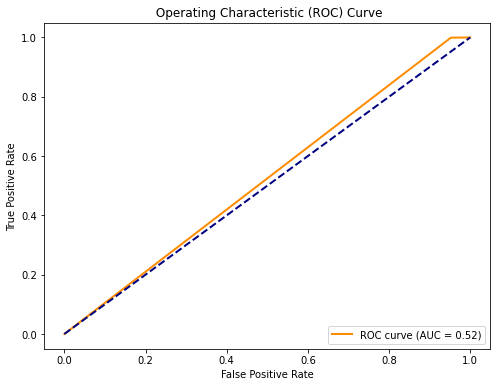

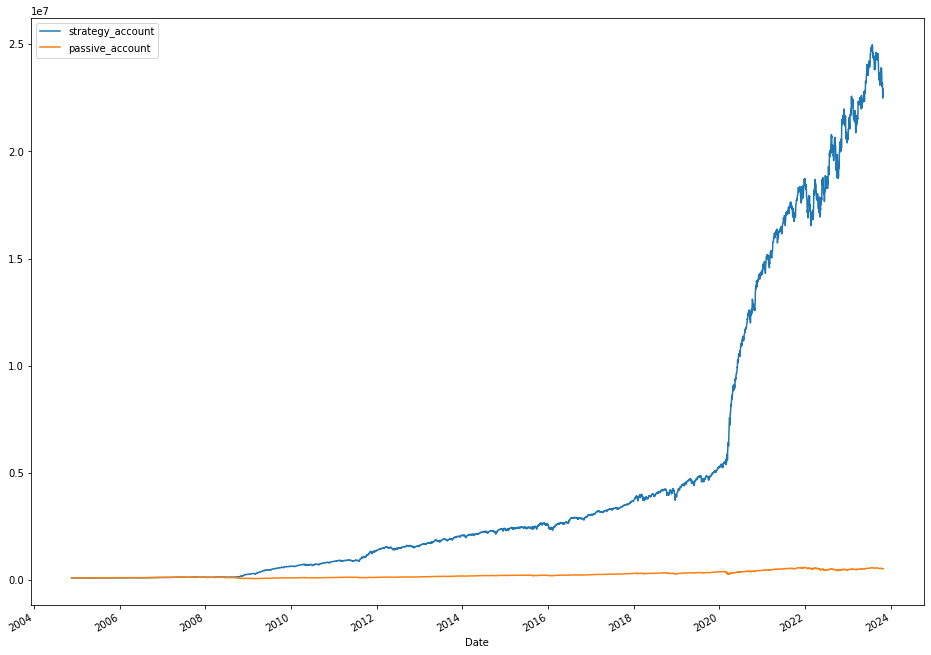

In [10]:
LR = LinearRegression()
LR.fit(X_selected_df, Y_traintest_binary)

print("=================================================================================")

print("Linear regression has intercept of {:.3f} and coefficients of {}".format(LR.intercept_, LR.coef_))
print(" ")

#linear regression
LR_pred_train = LR.predict(X_selected_df)
LR_pred_train_df = pd.DataFrame(LR_pred_train, columns = ['predicted'], index = index_)

#turn all linear regression predictions into binary response of 1 or 0
Y_pred_binary = (LR_pred_train_df > 0).astype(int)

#logistic regression
logreg_sk = LogisticRegression(penalty='elasticnet', l1_ratio=0, solver='saga')
logreg_sk.fit(X_selected_df, Y_pred_binary)

print("Logistic regression has intercept of {:.3f} and coefficients of {}".format(logreg_sk.intercept_[0], logreg_sk.coef_[0]))
print(" ")

Y_pred_logistic = logreg_sk.predict(X_selected_df)
Y_pred_logistic_df = pd.DataFrame(Y_pred_logistic, columns=['predicted'], index = index_)

print("=================================================================================")

print("Accuracy of model is : {:.3f}".format(metrics.accuracy_score(Y_traintest_binary,Y_pred_logistic_df)))
print(" ")
print("Precision of model is : {:.3f}".format(metrics.precision_score(Y_traintest_binary,Y_pred_logistic_df)))
print(" ")
print("Precision of model is : {:.3f}".format(metrics.recall_score(Y_traintest_binary,Y_pred_logistic_df)))
print(" ")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_traintest_binary, Y_pred_logistic)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("=================================================================================")

X_traintest1 = X.copy()
X_traintest1["signal"] =  Y_pred_logistic_df
X_traintest1 = X_traintest1.loc[pd.to_datetime('2004-11-17'):]
X_traintest1 = X_traintest1.ffill()

X_traintest1['strategy_return'] = X_traintest1["signal"] * Y
capital = 100000
X_traintest1['strategy_account'] = X_traintest1['strategy_return'].cumsum().apply(np.exp) * capital
X_traintest1['passive_account'] = Y.cumsum().apply(np.exp) * capital


fig, ax1 = plt.subplots(figsize = [16,12])
X_traintest1['strategy_account'].plot(ax=ax1, label='strategy_account')
X_traintest1['passive_account'].plot(ax=ax1, label='passive_account')
ax1.legend()

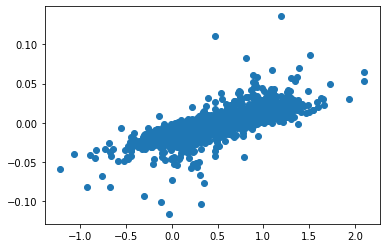

In [11]:
plt.scatter(LR_pred_train, Y_traintest)

# positive linear relationship predictions are close to actual values

+-----------------------+---------------+
|             Statistic |         Value |
+-----------------------+---------------+
| Final Account Balance | $ 22899093.02 |
|    Cummulative return |     22768.25% |
|         Strategy CAGR |        33.08% |
|          Max Drawdown |       -13.62% |
|          Sharpe Ratio |         1.805 |
|         Sortino Ratio |         3.445 |
+-----------------------+---------------+


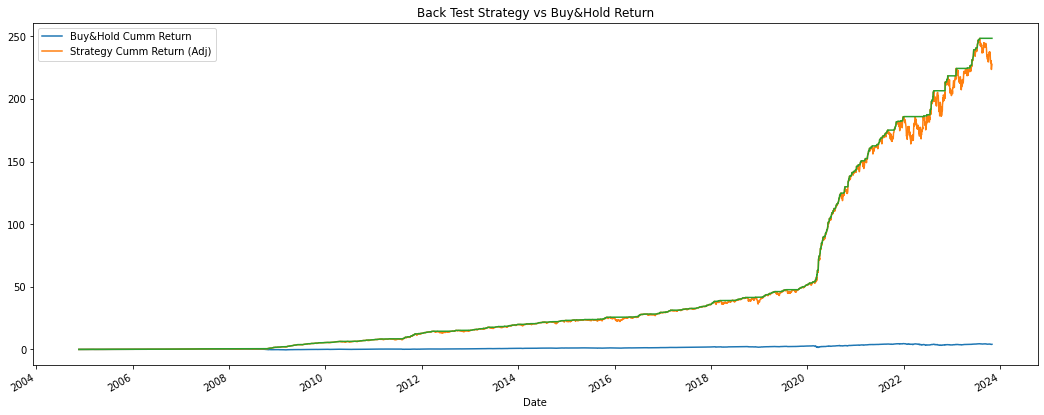

% Return by Quarter:
+------+----------+----------+----------+----------+
| year |       Q1 |       Q2 |       Q3 |       Q4 |
+------+----------+----------+----------+----------+
| 2004 |      nan |      nan |      nan |  2.27474 |
| 2005 | -2.02422 |    1.442 |  3.67827 |  1.73117 |
| 2006 |  4.68743 |  -1.5308 |  5.41128 |  6.60957 |
| 2007 |  4.75755 |  6.39316 |  5.02271 |  1.11903 |
| 2008 | -4.51398 |  0.67246 | 11.04176 | 75.50843 |
| 2009 | 27.11919 | 37.42633 | 18.29171 |   12.055 |
| 2010 | 11.25926 | -3.51348 | 14.29405 | 10.76084 |
| 2011 |  5.89738 |  0.02585 | 15.84915 | 28.56426 |
| 2012 | 12.69092 | -2.84412 |  6.34724 | -0.38208 |
| 2013 | 10.50265 |  2.93538 |  5.24181 |  10.5248 |
| 2014 |  1.70308 |  5.15898 |  1.13478 |  4.90022 |
| 2015 |  0.88132 |   0.2041 |  0.72134 |  7.02048 |
| 2016 |  1.32928 |  6.27303 |  3.77728 |  3.95168 |
| 2017 |  5.92116 |  3.07085 |  4.41553 |  6.76434 |
| 2018 |  3.32604 |  3.55239 |  7.65119 | -6.08964 |
| 2019 | 14.22289 |  4.22

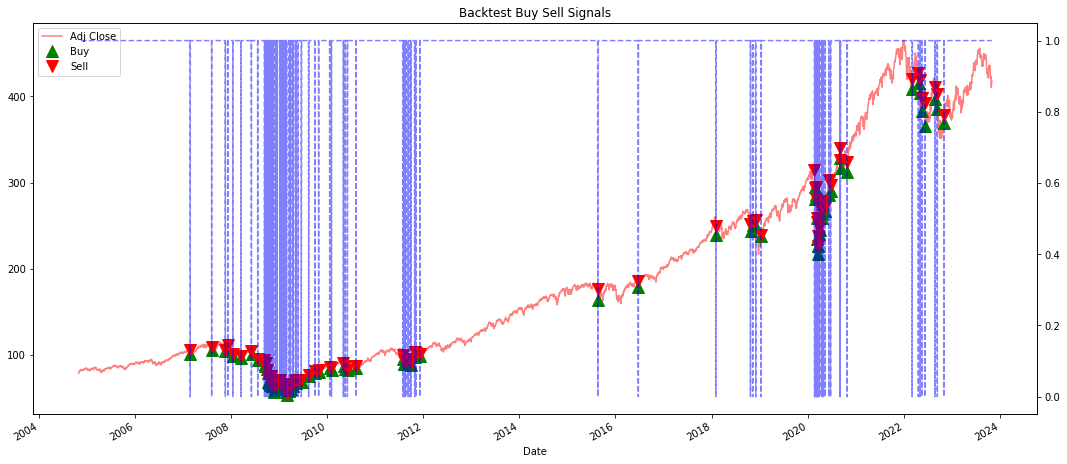

In [12]:
#create dataframe suitable for backtest Class 
reporting_df=pd.concat([spy["Adj Close"],X_traintest1["signal"]],axis=1)
reporting_df.columns=['Adj Close','Position']

#Generate Stats
Backtest_Strategy1=Backtest(reporting_df,100000,0)
Backtest_Strategy1.plot_all_stats()

# optimization

In [13]:
res1 = pd.DataFrame(columns =['balance', 'degree', 'k', 'penalty_'])

#for long-only strategy
def optimise1(X_traintest, Y_traintest, get_backtest = False, res = res1, degree=3, k=10, penalty_=0, solver= 'saga', capital = 100000): 
    
    Y_traintest_binary = (Y_traintest > 0).astype(int)
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_traintest)
    
    index_ = X_traintest.index

    feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'Volume_3', 'Volume_6', 'Volume_12', 'SPY_3', 'SPY_6', 'SPY_12']) 
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index = index_)
    
     # select the top 10 features based on the F-scores
    selector = SelectKBest(score_func=f_regression, k=k) 
    X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
    X_columns = selector.get_feature_names_out()
    X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)
    
    LN = LinearRegression()
    LN.fit(X_selected_df, Y_traintest_binary)
    LN_pred_train = LN.predict(X_selected_df)
    LN_pred_train_df = pd.DataFrame(LN_pred_train, columns = ['predicted'], index = index_) 

    Y_pred_binary = (LN_pred_train_df > 0).astype(int)
    
    if len(Y_pred_binary['predicted'].unique()) == 1:
        return print("Combination: degree = {degree}, polynomial HP {k}, regularization's L1ratio {penalty_}, output only has 1 class of predictions!".format(degree, k, penalty_))
    
    logreg_sk = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver=solver)
    
    logreg_sk.fit(X_selected_df, Y_pred_binary)
    
    Y_pred_logistic = logreg_sk.predict(X_selected_df)
    Y_pred_logistic_df = pd.DataFrame(Y_pred_logistic, columns=['predicted'])
    Y_pred_logistic_df.index = index_
    
    X_traintest2 = X.iloc[12:].copy()
    X_traintest2["signal"] =  Y_pred_logistic_df
    X_traintest2['strategy_return'] = X_traintest2["signal"] * Y
    X_traintest2['strategy_account'] = X_traintest2['strategy_return'].cumsum().apply(np.exp) * capital
    X_traintest2['passive_account'] = Y.cumsum().apply(np.exp) * capital
    
    balance2 = X_traintest2['strategy_account'].dropna()[-1]
    res.loc[len(res)] = [balance2, degree, k, penalty_]
    
    if get_backtest:
        reporting_df = pd.concat([spy["Adj Close"], X_traintest2["signal"]],axis=1)
        reporting_df.columns=['Adj Close','Position']

        return reporting_df, X_traintest2["signal"]

In [14]:
res1 = pd.DataFrame(columns =['account_balance', 'degree', 'k', 'penalty_'])

degree_list = [2,3]
k_list = np.arange(5, 15)
penalty_list = [0, 0.1, 0.2]

combi = [(degree, k, penalty_)
         for degree in degree_list
         for k in k_list
         for penalty_ in penalty_list]

for degree, k, penalty_ in combi:
    (
    optimise1(X_traintest, 
              Y_traintest, 
              get_backtest = False, 
              res = res1, 
              degree=degree, 
              k=k, 
              penalty_=penalty_, 
              solver= 'saga', 
              capital = 100000)
    )

In [15]:
res1.sort_values('account_balance', ascending=False).head(5)

,account_balance,degree,k,penalty_
17,3.467652e+07,2.0,10.0,0.2
16,3.467652e+07,2.0,10.0,0.1
15,3.467652e+07,2.0,10.0,0.0
20,3.312352e+07,2.0,11.0,0.2
19,3.312352e+07,2.0,11.0,0.1


+-----------------------+---------------+
|             Statistic |         Value |
+-----------------------+---------------+
| Final Account Balance | $ 34676516.57 |
|    Cummulative return |     34529.81% |
|         Strategy CAGR |        36.02% |
|          Max Drawdown |       -13.62% |
|          Sharpe Ratio |         1.956 |
|         Sortino Ratio |         3.806 |
+-----------------------+---------------+


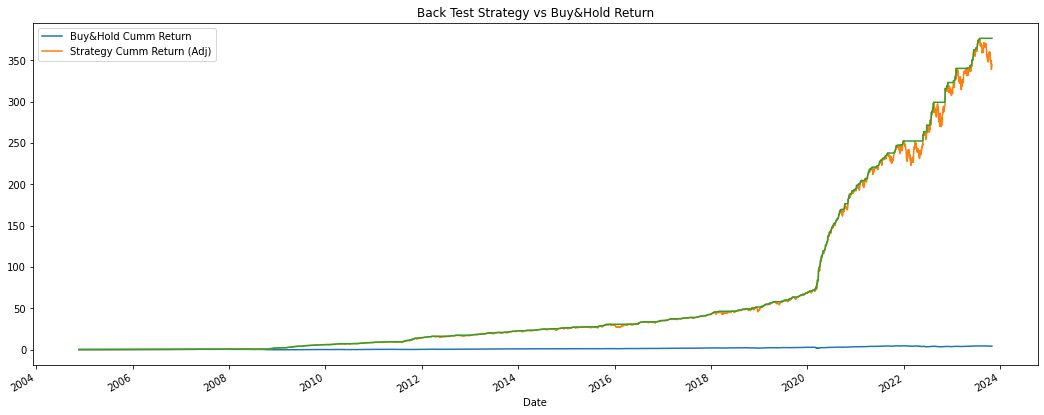

% Return by Quarter:
+------+----------+----------+----------+----------+
| year |       Q1 |       Q2 |       Q3 |       Q4 |
+------+----------+----------+----------+----------+
| 2004 |      nan |      nan |      nan |  2.27474 |
| 2005 | -2.02422 |    1.442 |  3.67827 |  1.73117 |
| 2006 |  4.68743 |  -1.5308 |  5.41128 |  6.60957 |
| 2007 |  4.75755 |  6.39316 |  5.02271 |  3.96302 |
| 2008 | -1.88711 |  0.67246 | 11.04176 | 74.23548 |
| 2009 | 27.11919 | 37.42633 | 21.61089 |   12.055 |
| 2010 | 11.25926 | -1.17622 | 14.29405 | 10.76084 |
| 2011 |  5.89738 |  0.02585 | 15.84915 | 28.56426 |
| 2012 | 12.69092 | -0.33487 |  6.34724 | -0.38208 |
| 2013 | 10.50265 |  2.93538 |  5.24181 |  10.5248 |
| 2014 |  1.70308 |  5.15898 |  1.13478 |  4.90022 |
| 2015 |  2.22976 |   0.2041 |  3.82011 |  7.02048 |
| 2016 |  1.32928 |  6.27303 |  3.77728 |  3.95168 |
| 2017 |  5.92116 |  3.07085 |  4.41553 |  6.76434 |
| 2018 |  3.32604 |  3.55239 |  7.65119 | -0.71186 |
| 2019 | 14.22289 |  4.22

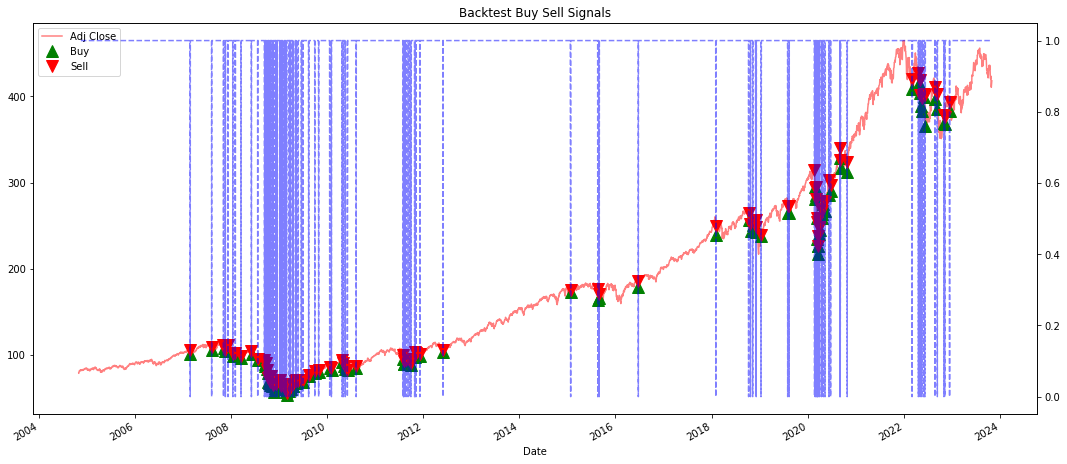

In [16]:
#unpacking the optimized params
account_balance1, degree1, k1, penalty_1 = res1.sort_values('account_balance', ascending=False).iloc[0]

#fit the optimized params into the function to get backtest results
reporting_df2, signal1 =\
(optimise1(X_traintest, 
           Y_traintest, 
           get_backtest = True, 
           res= res1, 
           degree=int(degree1), 
           k=int(k1), 
           penalty_=penalty_1, 
           solver= 'saga', 
           capital = 100000)
)

#Generate Stats
Backtest_Strategy2=Backtest(reporting_df2,100000,0)
Backtest_Strategy2.plot_all_stats()

In [17]:
#for long and short strategy

def optimise2(X_traintest, Y_traintest, long_short=True, get_backtest = False, res = res1, degree=3, k=10, penalty_=0, solver= 'saga', capital = 100000): 
        
    Y_traintest_binary = (Y_traintest > 0).astype(int)
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_traintest)
    
    index_ = X_traintest.index

    feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'Volume_3', 'Volume_6', 'Volume_12', 'SPY_3', 'SPY_6', 'SPY_12']) 
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index = index_)
    
     # select the top 10 features based on the F-scores
    selector = SelectKBest(score_func=f_regression, k=k) 
    X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
    X_columns = selector.get_feature_names_out()
    X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)
    
    LN = LinearRegression()
    LN.fit(X_selected_df, Y_traintest_binary)
    LN_pred_train = LN.predict(X_selected_df)
    LN_pred_train_df = pd.DataFrame(LN_pred_train, columns = ['predicted'], index = index_) 
    Y_pred_binary = (LN_pred_train_df > 0).astype(int)
    
    if len(Y_pred_binary['predicted'].unique()) == 1:
        return print("Combination: degree = {degree}, polynomial HP {k}, regularization's L1ratio {penalty_}, output only has 1 class of predictions!".format(degree, k, penalty_))
    
    logreg_sk = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver=solver)
    
    logreg_sk.fit(X_selected_df, Y_pred_binary)
    
    Y_pred_logistic = logreg_sk.predict(X_selected_df)
    
    if long_short: 
        signal = Y_pred_logistic
        short_signal = (signal == 0) * -1 
        signals = short_signal + signal

    Y_pred_logistic_df = pd.DataFrame(Y_pred_logistic, columns=['predicted'])
    Y_pred_logistic_df.index = index_
    
    X_traintest3 = X.iloc[12:].copy()
    X_traintest3["signal"] = signals
    X_traintest3['strategy_return'] = X_traintest3["signal"] * Y
    X_traintest3['strategy_account'] = X_traintest3['strategy_return'].cumsum().apply(np.exp) * capital
    X_traintest3['passive_account'] = Y.cumsum().apply(np.exp) * capital

    balance3 = X_traintest3['strategy_account'].dropna()[-1]
    res.loc[len(res)] = [balance3, degree, k, penalty_]
    
    if get_backtest:
        reporting_df2 = pd.concat([spy["Adj Close"], X_traintest3["signal"]],axis=1)
        reporting_df2.columns=['Adj Close','Position']

        return reporting_df2, X_traintest3["signal"]

In [18]:
degree_list = [2,3]
k_list = np.arange(5, 15)
penalty_list = [0, 0.1, 0.2]

combi = [(degree, k, penalty_)
        for degree in degree_list
        for k in k_list
        for penalty_ in penalty_list]

res2 = pd.DataFrame(columns =['account_balance', 'degree', 'k', 'penalty_'])

for degree, k, penalty_ in combi:
    (
    optimise2(X_traintest, 
              Y_traintest, 
              long_short=True, 
              get_backtest = False, 
              res = res2, 
              degree=degree, 
              k=k, 
              penalty_=penalty_, 
              solver= 'saga', 
              capital = 100000)
    )

In [19]:
res2.sort_values('account_balance', ascending=False).head(5)

,account_balance,degree,k,penalty_
17,2.368487e+09,2.0,10.0,0.2
16,2.368487e+09,2.0,10.0,0.1
15,2.368487e+09,2.0,10.0,0.0
20,2.161091e+09,2.0,11.0,0.2
19,2.161091e+09,2.0,11.0,0.1


+-----------------------+-----------------+
|             Statistic |           Value |
+-----------------------+-----------------+
| Final Account Balance | $ 2368486813.73 |
|    Cummulative return |     2365196.43% |
|         Strategy CAGR |          69.87% |
|          Max Drawdown |         -12.82% |
|          Sharpe Ratio |           2.850 |
|         Sortino Ratio |           6.495 |
+-----------------------+-----------------+


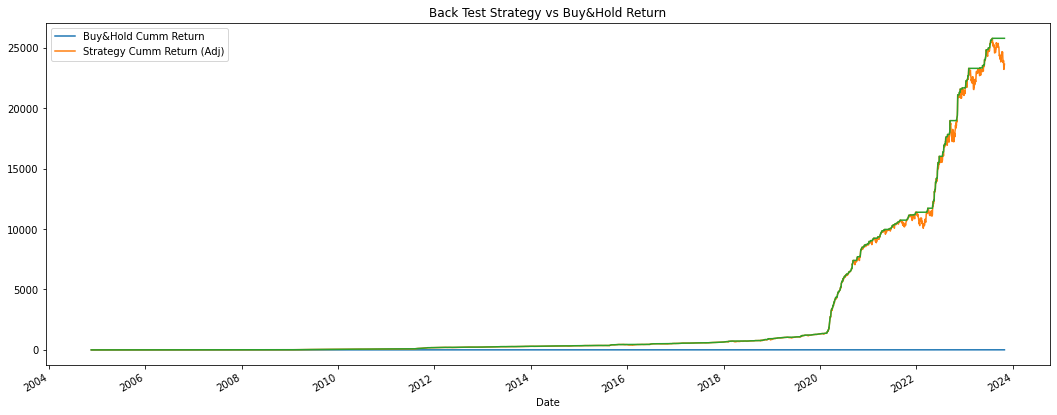

% Return by Quarter:
+------+-----------+----------+----------+-----------+
| year |        Q1 |       Q2 |       Q3 |        Q4 |
+------+-----------+----------+----------+-----------+
| 2004 |       nan |      nan |      nan |   2.27474 |
| 2005 |  -2.02422 |    1.442 |  3.67827 |   1.73117 |
| 2006 |   4.68743 |  -1.5308 |  5.41128 |   6.60957 |
| 2007 |   9.01538 |  6.39316 |  8.22996 |  12.19658 |
| 2008 |   6.12292 |  3.98906 | 35.26569 | 287.06463 |
| 2009 |  82.07383 | 62.41204 |   28.177 |  18.33474 |
| 2010 |  17.42024 | 10.17511 | 17.51478 |  10.76084 |
| 2011 |   5.89738 |  0.02585 | 55.72743 |  48.08319 |
| 2012 |  12.69092 |  2.23918 |  6.34724 |  -0.38208 |
| 2013 |  10.50265 |  2.93538 |  5.24181 |   10.5248 |
| 2014 |   1.70308 |  5.15898 |  1.13478 |   4.90022 |
| 2015 |   3.59622 |   0.2041 | 15.18568 |   7.02048 |
| 2016 |   1.32928 | 10.23134 |  3.77728 |   3.95168 |
| 2017 |   5.92116 |  3.07085 |  4.41553 |   6.76434 |
| 2018 |     7.836 |  3.55239 |  7.65119 |  

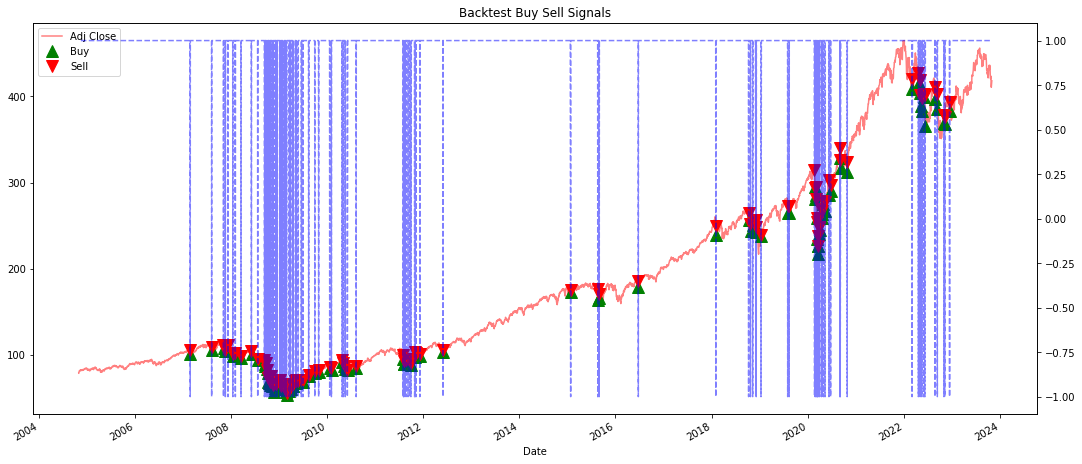

In [20]:
#unpacking the optimized params
account_balance2, degree2, k2, penalty_2 = res2.sort_values('account_balance', ascending=False).iloc[0]

#fit the optimized params into the function to get backtest results
reporting_df2, signal2 =\
(optimise2(X_traintest, 
           Y_traintest, 
           get_backtest = True, 
           res= res2, 
           degree=int(degree2), 
           k=int(k2), 
           penalty_=penalty_2, 
           solver= 'saga', 
           capital = 100000)
)



#Generate Stats
Backtest_Strategy2=Backtest(reporting_df2,100000,0)
Backtest_Strategy2.plot_all_stats()

In [22]:
"""observation: The 2 strategies of long-only and long&short appears to have the same % return by quarter. 
After careful analysis, we conclude that it is not because they are the same but the difference is neligible."""

'observation: The 2 strategies of long-only and long&short appears to have the same % return by quarter. \nAfter careful analysis, we conclude that it is not because they are the same but the difference is neligible.'

In [23]:
signal1-signal1.diff()

Date
2004-11-17    NaN
2004-11-18    1.0
2004-11-19    1.0
2004-11-22    1.0
2004-11-23    1.0
             ... 
2023-10-25    1.0
2023-10-26    1.0
2023-10-27    1.0
2023-10-30    1.0
2023-10-31    1.0
Name: signal, Length: 4771, dtype: float64

In [24]:
signal2

Date
2004-11-17    1
2004-11-18    1
2004-11-19    1
2004-11-22    1
2004-11-23    1
             ..
2023-10-25    1
2023-10-26    1
2023-10-27    1
2023-10-30    1
2023-10-31    1
Name: signal, Length: 4771, dtype: int64

In [26]:
signal2.shape[0]-(signal1==signal2).sum() #number of different signal

121

# CART (classification and regression decision tree)
- (classification) builds a binary tree that splits datasets into subsets (e.g. of diff years) to predict future
- (regression) mse
- pros:
    - capable of handling complex nonlinear relatinoships
- cons:
    - prone to overfitting 
    - small data change can lead to diff splits

In [27]:
def get_polynomial_features(X_traintest, Y_traintest, *args):
    
    k = arg[0] if args else "all"
    
    Y_traintest_binary = (Y_traintest > 0).astype(int)
    
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X_traintest)

    feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'Volume_3', 'Volume_6', 'Volume_12', 'SPY_3', 'SPY_6', 'SPY_12'])
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
    X_poly_df.index = index_
    
    selector = SelectKBest(score_func=f_regression, k=k) 

    X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
    X_columns = selector.get_feature_names_out()
    X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

DT_model = DecisionTreeRegressor(criterion='squared_error')
get_polynomial_features(X_traintest, Y_traintest)

DT_model.fit(X_selected_df, Y_traintest.ffill())
DT_pred_train2 = DT_model.predict(X_selected_df)
train_result_mse = mean_squared_error(Y_traintest.ffill(), DT_pred_train2)
print('mse = ', train_result_mse)

DT_pred_train2_df = pd.DataFrame(DT_pred_train2, index=index_, )

X_traintest_dt = X_selected_df.copy()
X_traintest_dt['signal'] = DT_pred_train2_df
X_traintest_dt['signal'] = np.sign(X_traintest_dt['signal'])

mse =  0.0


strategy final balance =  1.3544951081445506e+21


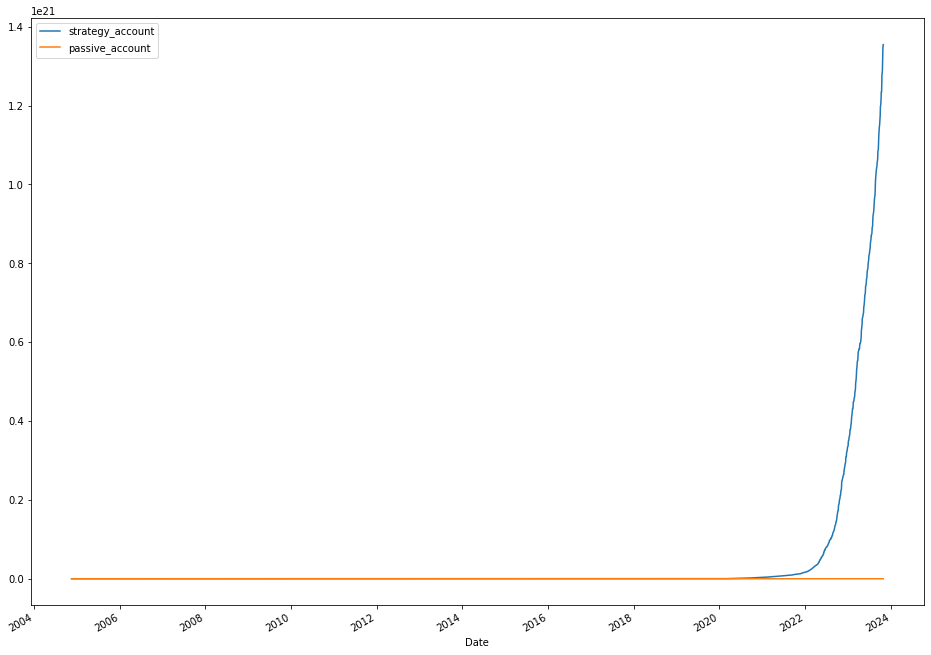

In [32]:
X_traintest_dt['strategy_return'] = X_traintest_dt["signal"] * Y
X_traintest_dt['strategy_account'] = X_traintest_dt['strategy_return'].cumsum().apply(np.exp) * capital
X_traintest_dt['passive_account'] = Y.cumsum().apply(np.exp) * capital

fig, ax1 = plt.subplots(figsize = [16,12])
X_traintest_dt['strategy_account'].plot(ax=ax1, label='strategy_account')
X_traintest_dt['passive_account'].plot(ax=ax1, label='passive_account')
ax1.legend()

print('strategy final balance = ', X_traintest_dt['strategy_account'].dropna()[-1])

In [30]:
reporting_df4=pd.concat([spy["Adj Close"],X_traintest_dt["signal"]],axis=1)
reporting_df4.columns=['Adj Close','Position']

+-----------------------+-----------------------------+
|             Statistic |                       Value |
+-----------------------+-----------------------------+
| Final Account Balance | $ 1354495108144521543680.00 |
|    Cummulative return |     1352670587064476672.00% |
|         Strategy CAGR |                     605.74% |
|          Max Drawdown |                       0.00% |
|          Sharpe Ratio |                      12.964 |
|         Sortino Ratio |                         inf |
+-----------------------+-----------------------------+


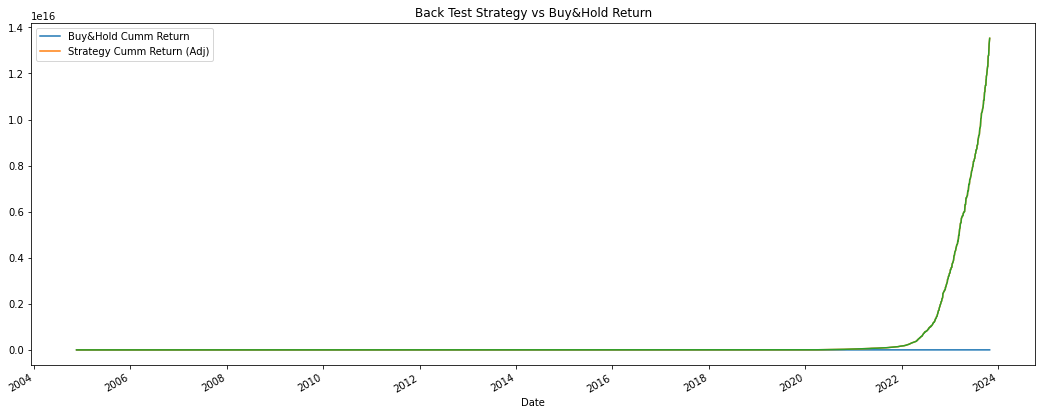

% Return by Quarter:
+------+-----------+-----------+-----------+-----------+
| year |        Q1 |        Q2 |        Q3 |        Q4 |
+------+-----------+-----------+-----------+-----------+
| 2004 |       nan |       nan |       nan |  10.85075 |
| 2005 |   38.1208 |  43.07713 |  33.83766 |  38.30602 |
| 2006 |  33.17727 |  48.63655 |  32.10281 |  24.20764 |
| 2007 |  36.36028 |  37.58516 |  75.12288 |  85.72616 |
| 2008 | 101.93969 |  60.72444 | 159.72826 |  773.3864 |
| 2009 | 236.27845 | 122.46856 |  67.35015 |  65.47247 |
| 2010 |  49.76822 | 107.80563 |  70.23889 |  38.60054 |
| 2011 |  47.73945 |  48.33915 | 165.88178 | 130.16325 |
| 2012 |  33.99647 |  66.76017 |  37.55559 |  43.38737 |
| 2013 |  33.46039 |  58.42467 |  33.11621 |   38.6114 |
| 2014 |  41.01306 |  32.54774 |  32.09331 |  51.36533 |
| 2015 |  54.25377 |  36.02103 |  79.92518 |  59.85156 |
| 2016 |   72.0823 |  48.09705 |  30.88453 |  28.91088 |
| 2017 |  22.44915 |  22.92291 |  19.96193 |   19.0596 |
| 2018 |  

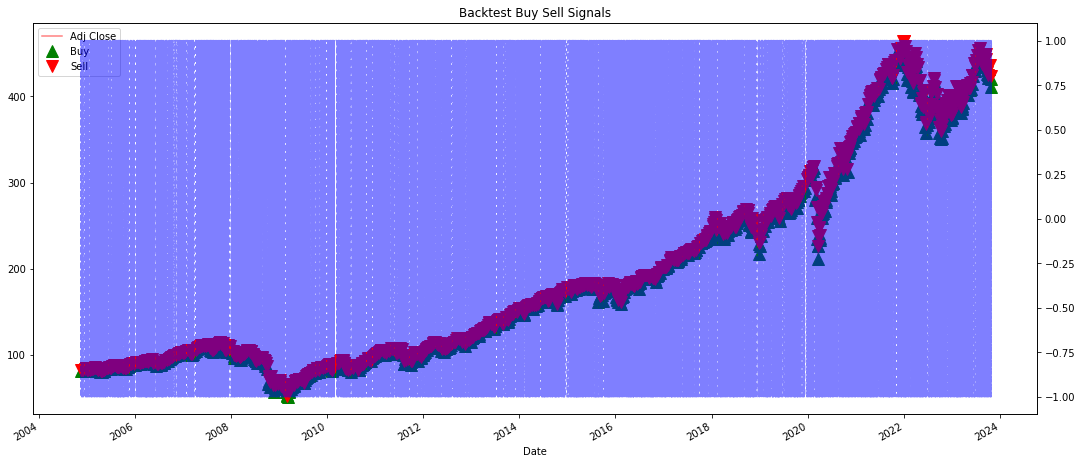

In [31]:
#Generate Stats
Backtest_Strategy4=Backtest(reporting_df4,100000,0)
Backtest_Strategy4.plot_all_stats()

<font color = 'red'>

> elastic net
- independet var
    - raw = Y
    - Y_traintest
    - Y_traintest_binary
    
- predicted
    - EN_pred_train2 (non-binary)
    - EN_pred_train2_df (binary)
    - binary = Y_pred_logistic2_df
        - elasticNet + logisticRegression 
            - long only --> (store in 'res1') highest balance 1.005e+07, degree 2, k 15, alpha 0.1, penalty 0
            - long short --> (store in 'res2') highest balance 3.03e+07, degree 3, k 5, alpha 0.2, penalty 0.1
     

- indepedent var 
    - raw  = X
    - X_traintest
    - PolynomialFeatures = X_poly_df
    - kmeans = X_selected_df

- index = index_
    
- 4771
- 2004-11-17 to 2023-10-31
    
- stacking models: to correct error in model1, feed model1 prediction into model2
    - elastic net: benefit from regularisation
    - logistic regression: benefit from
        - specialisation in binary task
        - make use of performance metrics (e.g. accuracy, precision, recall)
    
> cart 
- x var (data from diff years) = df_dict
- Y
    - predicted (long short): DT_pred_train2
        - 100% overfitting, mse=0, strategy final balance = 1.3544955853277257e+21